# Modeling with a Bootstrapped Version of the Word Embedding Dataset

Sometimes people use bootstrapping to up-sample their dataset to make it balanced. I would like to try it here to see if it will change the performance of the machine learning models. It may not change the noise of the data, but I am curious to see what happens.

In [23]:
import gensim
from gensim import utils
import tempfile
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

In [2]:
# Load the genims model
model_name = 'gensim-model-i5jx6hf4'
model = gensim.models.Word2Vec.load(model_name)

## Create the Dataframe

In [3]:
# Define functions needed
# This calculates and returns an average word vector for a document
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for token in tokens:
        try:
            vec += model.wv[token].reshape((1, size))
            count += 1
        except KeyError: # handle out of vocabulary errors
            continue
    if count != 0:
        vec /= count
        return vec

# This calculates and returns the number of documents in a corpus so the array is constructed correctly
def calculate_num_docs(corpus):
    num_docs = 0
    for i, doc in enumerate(corpus):
        num_docs += 1
    return num_docs

In [4]:
# Import the reviews dataframe
yelp_reviews = pd.read_csv('yelp_reviews_v3.csv')
yelp_reviews.drop("Unnamed: 0", axis = 1, inplace = True)
yelp_reviews.head(5)

,date,review,rating,isEdited,title,userName,developerResponse
0,2024-11-22 22:44:23,I say it can be fantastic because some people ...,5,False,Yelp can be fantastic,Robg80,NaN
1,2024-12-12 22:08:33,Yelp's developers have been spamming false 5-s...,1,False,Review botting should not be tolerated!,itsbad):,NaN
2,2024-10-11 18:43:56,I will not be using Yelp ever again. After a t...,1,False,Horrible,jennausuwiajdneka,NaN
3,2024-09-22 20:35:32,During think tank meetings with other business...,1,False,Is yelp fair?,Srepman,"{'id': 46973211, 'body': 'Thank you for taking..."
4,2024-12-13 03:52:13,If I could give this place a 0 star I absolute...,1,False,Horrible service,Tsimmons96,NaN


In [5]:
# Define a generator that will yield each document and preprocess it
class CorpusGenerator:
    def __iter__(self):
        for doc in yelp_reviews['review']:
            yield utils.simple_preprocess(doc)

In [6]:
# Use the functions to create the new dataframe
yelp_corpus = CorpusGenerator()

num_docs = calculate_num_docs(yelp_corpus) # calculate the number of docs to determine the number of rows needed

wordvec_arrays = np.zeros((num_docs, 300)) # 300 dimensions/features for each word vector

for i, doc in enumerate(yelp_corpus):
    wordvec_arrays[i, :] = word_vector(doc, 300) # change each row (doc) to the corresponding word vector
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(20000, 300)

In [7]:
wordvec_df['label'] = yelp_reviews['rating']

In [8]:
wordvec_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,label
0,-0.227540,-0.170826,0.115066,0.149463,-0.026197,0.008393,-0.024517,0.025794,0.067489,0.097428,...,0.172643,0.034766,0.276930,0.098627,-0.086076,-0.055905,-0.056114,-0.002599,0.101394,5
1,-0.199238,-0.200579,0.116510,0.111658,-0.064551,0.020515,-0.017088,0.006766,0.083793,0.163523,...,0.178555,0.034858,0.283163,0.098012,-0.086388,-0.065492,-0.055511,-0.080624,0.102011,1
2,-0.229403,-0.180689,0.149343,0.133359,-0.036580,0.031731,-0.011592,-0.025878,0.081141,0.153825,...,0.177649,0.016944,0.292426,0.114490,-0.116326,-0.075048,-0.072371,-0.070862,0.127622,1
3,-0.237999,-0.193224,0.123863,0.154978,-0.065055,0.050980,0.001317,0.003766,0.086413,0.102024,...,0.149542,0.012284,0.302916,0.106729,-0.074216,-0.042382,-0.052624,-0.039711,0.112512,1
4,-0.203110,-0.214482,0.103448,0.181231,0.010507,-0.013264,-0.050693,0.035647,0.080304,0.143670,...,0.180557,0.059697,0.240646,0.098397,-0.047990,-0.073707,-0.052928,-0.058238,0.162846,1


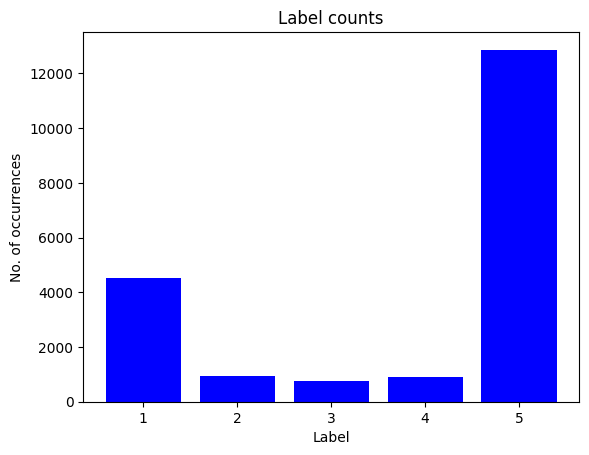

label
1     4509
2      948
3      765
4      914
5    12864
Name: count, dtype: int64


In [9]:
label_counts = wordvec_df.label.value_counts().sort_index()
plt.figure()
plt.bar(label_counts.index, label_counts.values, color = 'blue')
plt.title('Label counts')
plt.xlabel('Label')
plt.ylabel('No. of occurrences')
plt.show()
print(label_counts)

In [11]:
# Do a train-test-split to make sure that the upsampled data does not contribute to data leakage
train, test = train_test_split(wordvec_df, test_size = 0.2, random_state = 3)

In [16]:
train_label_counts = train.label.value_counts().sort_index()
train_label_counts

label
1     3612
2      762
3      615
4      708
5    10303
Name: count, dtype: int64

In [36]:
# Calculate the number of samples to take from each category, store it in a list
n_samples = [train_label_counts[5] - train_label_counts[i] for i in range(1,5)] # doesn't include 5th label - 5th label


# Function that will append a resample of size n_samples[i] for that class to the training data
def upsample(df, upsample_counts, labels):
    for l, n in enumerate(upsample_counts):
        df = pd.concat([df, resample(df[df['label'] == labels[l]], replace = True, n_samples = n)])
    return df

train_upsampled = upsample(train, n_samples, [1, 2, 3, 4])
train_upsampled.label.value_counts().sort_index()

label
1    10303
2    10303
3    10303
4    10303
5    10303
Name: count, dtype: int64

Now the data has been upsampled using random oversampling

In [40]:
train_upsampled = train_upsampled.dropna(axis = 0, how = 'any')

In [41]:
train_upsampled.label.value_counts().sort_index()

label
1    10303
2    10303
3    10303
4    10303
5    10302
Name: count, dtype: int64

## Modeling and Evaluation (Multiclass problem)

In [45]:
# Set up X and y
X_train_upsampled = train_upsampled.drop('label', axis = 1)
y_train_upsampled = train_upsampled['label']
X_test = test.drop('label', axis = 1)
y_test = test['label']

In [47]:
# Create a Logistic Regression Model
lr_mdl = LogisticRegression(max_iter = 5000)

# Train the model
lr_mdl.fit(X_train_upsampled, y_train_upsampled)

# Make predictions
y_hat = lr_mdl.predict(X_test)

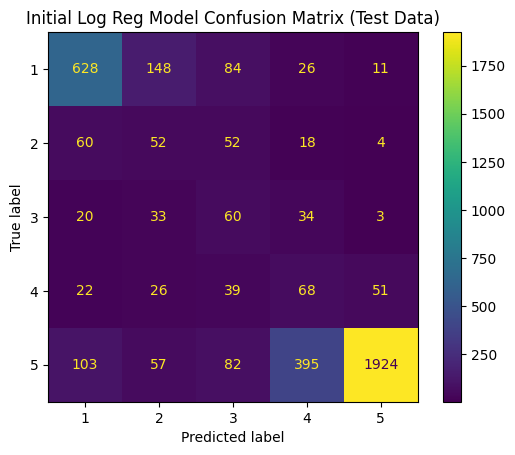

              precision    recall  f1-score   support

           1       0.75      0.70      0.73       897
           2       0.16      0.28      0.21       186
           3       0.19      0.40      0.26       150
           4       0.13      0.33      0.18       206
           5       0.97      0.75      0.84      2561

    accuracy                           0.68      4000
   macro avg       0.44      0.49      0.44      4000
weighted avg       0.81      0.68      0.73      4000



In [48]:
# Plot a confusion matrix and a classification report
def output_metrics(true, pred, cf_title, mdl):
    cf = confusion_matrix(true, pred, labels = mdl.classes_)
    cf_disp = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = mdl.classes_)
    cf_disp.plot()
    plt.title(cf_title)
    plt.show()
    print(classification_report(true, pred))

output_metrics(y_test, y_hat, "Initial Log Reg Model Confusion Matrix (Test Data)", lr_mdl)

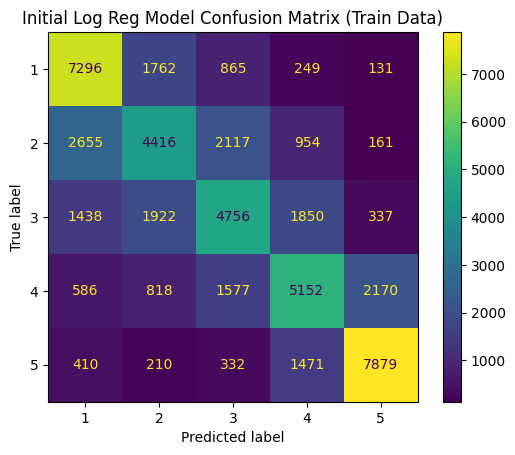

              precision    recall  f1-score   support

           1       0.59      0.71      0.64     10303
           2       0.48      0.43      0.45     10303
           3       0.49      0.46      0.48     10303
           4       0.53      0.50      0.52     10303
           5       0.74      0.76      0.75     10302

    accuracy                           0.57     51514
   macro avg       0.57      0.57      0.57     51514
weighted avg       0.57      0.57      0.57     51514



In [49]:
y_hat_train_upsampled = lr_mdl.predict(X_train_upsampled)

output_metrics(y_train_upsampled, y_hat_train_upsampled, "Initial Log Reg Model Confusion Matrix (Train Data)", lr_mdl)

As predicted, the model performed worse than with the downsampling